In [197]:
# Imports
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog

In [198]:


# Create the Tkinter root widget
# root = tk.Tk()
# root.withdraw()  # Hide the main window

# # Ask the user to select a file
# dyno_file_path = filedialog.askopenfilename(
#     title="Select the dyno run .txt file",
#     filetypes=[("All files", "*.*")],
#     initialdir="/",
#     message="Please select the dyno run .txt."
# )
# # Ask the user to select a file
# car_log_file_path = filedialog.askopenfilename(
#     title="Select the car log .csv file",
#     filetypes=[("All files", "*.*")],
#     initialdir="/",
#     message="Please select the car log csv."
# )
# dyno_file_path
dyno_file_path = "4-26-23_power_run.txt"
car_log_path = r"C:\Users\Matthew Samson\Documents\formula\4-26-2023_dyno_and_regen\parsed-data\parseddata0003.CSV"
dyno_file_path="your_file_reformatted.txt"
car_log_path=r"C:\Users\Matthew Samson\Documents\formula\228hv\parsed-data\parsedMDY_3-3-2024_HMS_3-58-56.CSV"


In [199]:
# # Read the file
# with open('dynoruns\DJDataExport_DYNORUN_015.txt', 'r') as file:
# # Read the file
#     lines = file.readlines()

# # Remove leading and trailing spaces, split columns, and exclude lines with 'N/A'
# formatted_lines = [line.strip().split() for line in lines if 'N/A' not in line]

# # Reformat the lines with tab delimiter
# formatted_text = '\n'.join(['\t'.join(line) for line in formatted_lines])

# # Write the reformatted text back to the file
# with open('your_file_reformatted.txt', 'w') as file:
#     file.write(formatted_text)



In [200]:
# Calculate some constants 
gear_tooth_count_motor = 10  # KS6e front sprocket
gear_tooth_count_wheel = 30  # KS6e rear sprocket

dyno_tire_diameter = 20.5 # ish inches 
normal_tire_diameter = 18 # ish inches
tire_diameter = dyno_tire_diameter # set to the right tire size when plotting

gear_ratio = gear_tooth_count_wheel / gear_tooth_count_motor

# Calculate wheel circumference
wheel_circumference = tire_diameter * 3.141592653589793  # Pi


In [201]:
# open dyno run file
dyno_run_df = pd.read_csv(dyno_file_path,delimiter="\t")
# drop shit rows
dynorun = dyno_run_df[dyno_run_df["s"]>=0]
# dynorun = dyno_run_df[dyno_run_df["hp"]>=0]
try:
    dynorun.drop(dynorun.columns[[0,4]],axis=1,inplace=True) # remove bs columns
except:
    pass
del(dyno_run_df)
dynorun["kw"] = dynorun['hp']/1.341 # add KW column
dynorun["wheel_rpm"] = dynorun["mph"] / ((wheel_circumference * 60)/63360 )
dynorun["wheel_torque"] = (9548.8 * dynorun["kw"])/dynorun["wheel_rpm"]
dynorun["motor_rpm"]=dynorun["wheel_rpm"]*gear_ratio
dynorun["motor_torque"] = dynorun["wheel_torque"] / gear_ratio
print("dynorun MAXES:")
dynorun.max()

dynorun MAXES:


s                 51.940000
mph               73.430000
hp                31.330000
kw                23.363162
wheel_rpm       1204.020032
wheel_torque     418.296234
motor_rpm       3612.060096
motor_torque     139.432078
dtype: float64

In [202]:
# load electrical log
vehicle_log = pd.read_csv(car_log_path)
# remove dfs we dont care about
vehicle_log = vehicle_log[["Time","D1_Commanded_Torque","D2_Torque_Feedback","D2_Motor_Speed"]]
# cancer time
from torque_log_analysis import resample_data,drop_rows_from_df
vehicle_log = resample_data(vehicle_log,"Time")
vehicle_log = drop_rows_from_df(vehicle_log,"D2_Motor_Speed",10,7000)
vehicle_log.max()


D1_Commanded_Torque     198.34
D2_Torque_Feedback      135.38
D2_Motor_Speed         4065.00
dtype: float64

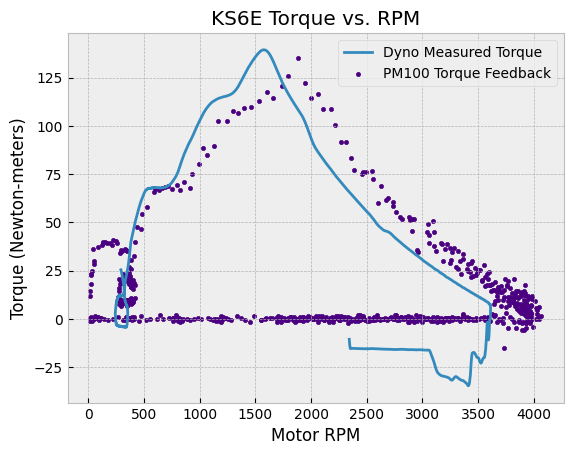

In [203]:
# plot torques and rpms to compare
plt.style.use('bmh')

plt.plot(dynorun["motor_rpm"],dynorun["motor_torque"],label="Dyno Measured Torque")
plt.scatter(vehicle_log["D2_Motor_Speed"],vehicle_log["D2_Torque_Feedback"],marker='.',color='indigo',label="PM100 Torque Feedback")
plt.xlabel("Motor RPM")
plt.ylabel("Torque (Newton-meters)")
plt.legend()
plt.title("KS6E Torque vs. RPM")
plt.show()

In [223]:
# Attempt to sync dyno and car log
dynorun["s"]=pd.to_datetime(dynorun["s"],unit="s")
vehlogstart = vehicle_log.index.min()
dynologstart = dynorun["s"].min()
timeoffset = vehlogstart-dynologstart
timeoffset
# this offset has to be manually adjusted lol :(
runoffset = pd.tseries.offsets.DateOffset(seconds=2,milliseconds=800)
dynorun["s"] = dynorun["s"]+timeoffset + runoffset
dynorun


,s,mph,hp,kw,wheel_rpm,wheel_torque,motor_rpm,motor_torque
0,2024-03-03 04:00:38.900,5.93,1.04,0.775541,97.233267,76.162025,291.699801,25.387342
1,2024-03-03 04:00:38.910,5.94,1.04,0.775541,97.397235,76.033806,292.191706,25.344602
2,2024-03-03 04:00:38.920,5.97,1.03,0.768084,97.889141,74.924306,293.667422,24.974769
3,2024-03-03 04:00:38.930,5.98,1.03,0.768084,98.053109,74.799014,294.159327,24.933005
4,2024-03-03 04:00:38.940,6.02,1.01,0.753169,98.708983,72.859254,296.126948,24.286418
...,...,...,...,...,...,...,...,...
3618,2024-03-03 04:01:23.120,47.70,-4.36,-3.251305,782.129314,-39.694281,2346.387942,-13.231427
3619,2024-03-03 04:01:23.130,47.69,-4.25,-3.169277,781.965346,-38.700934,2345.896037,-12.900311
3620,2024-03-03 04:01:23.140,47.67,-4.02,-2.997763,781.637409,-36.621888,2344.912227,-12.207296
3621,2024-03-03 04:01:23.150,47.66,-3.89,-2.900820,781.473440,-35.445034,2344.420321,-11.815011


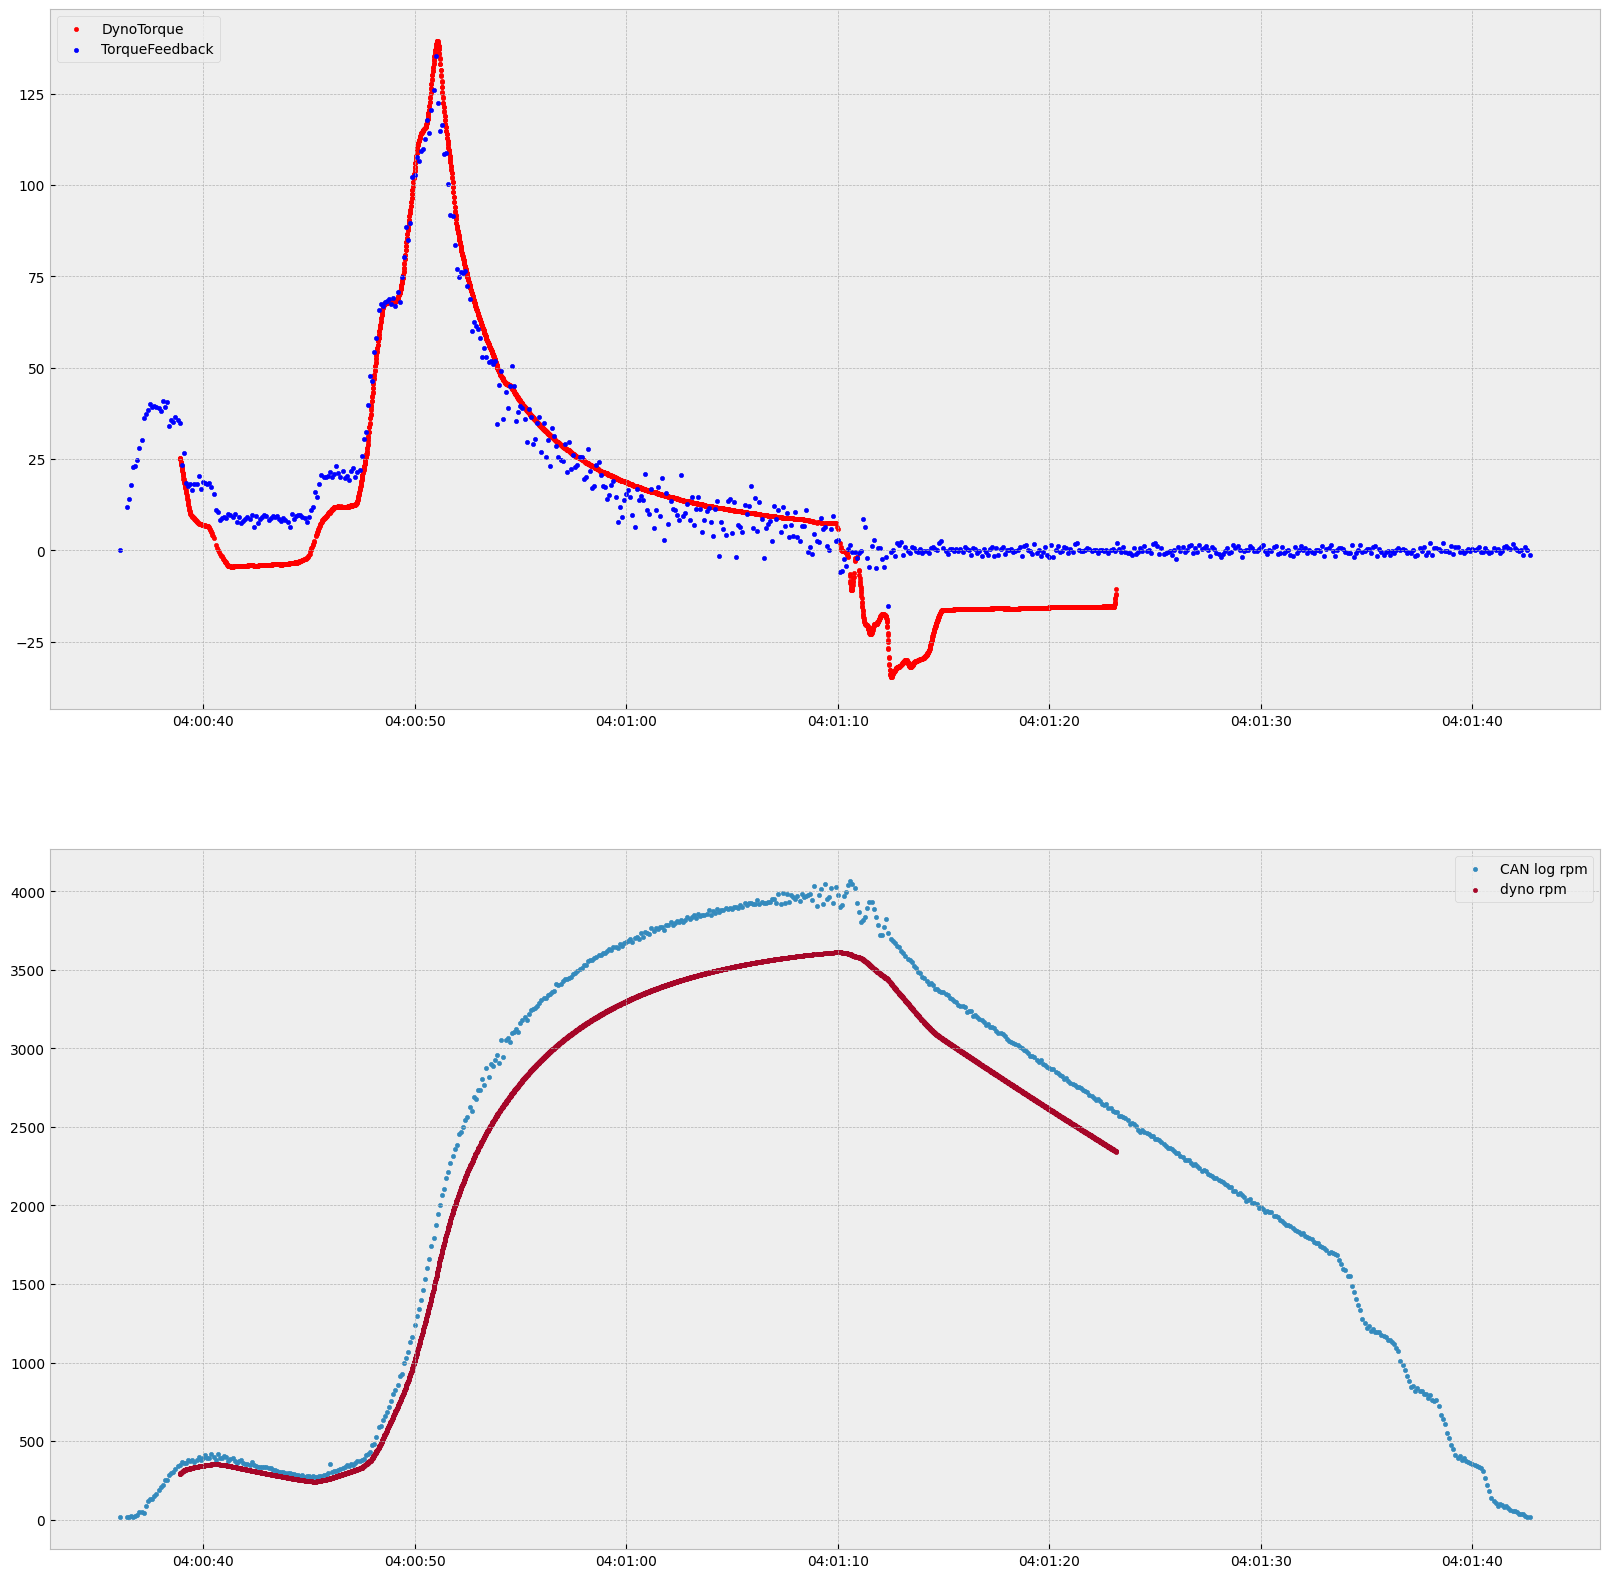

In [224]:
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2, (1, 2))
ax2 = fig.add_subplot(2,2, (3, 4))
ax1.scatter(dynorun["s"],dynorun['motor_torque'],label="DynoTorque",c="r",marker='.')
ax1.scatter(vehicle_log.index,vehicle_log['D2_Torque_Feedback'],label="TorqueFeedback",c="b",marker='.')

ax2.scatter(vehicle_log.index,vehicle_log["D2_Motor_Speed"],label="CAN log rpm",marker='.')
ax2.scatter(dynorun["s"],dynorun["motor_rpm"],label="dyno rpm",marker='.')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()